## <b> KNN Notebook </b>

### <b> Goals </b>

The goals of our project are focused around implementing ways to improve the way the KNN algorithm classifies binary data when consuming datasets that present heavy class imbalances.

### <b> Dataset Exploratory Data Analysis </b>

In the following section of the notebook our aim is to better understand our dataset.
As previously mentioned our main focus is to tackle KNN problems related to Binary Class Imbalances, therefore we'll start by checking if the datasets we'll be using actually do present those problems.

In [3]:
#Imports
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml #Fetch Method for OpenML datasets

##### <b> 1. Functions to extract data and observe binary class imbalances

In [4]:
#Function to fetch datasets and transform them into dataframe
def dataset_fetcher(dataset_id):
    #Fetch OpenML dataset
    dataset = fetch_openml(data_id=dataset_id, version='active', as_frame=True)

    dataset_name = dataset.details['name']

    #Convert dataset to pandas dataframe
    df = dataset.frame

    return df, dataset_name

#Function to show number of entries for each label/class
def item_number_per_class(dataframe, ds_name):

    #Select class column
    label_column = dataframe.iloc[:,-1]
    
    # Count the occurrences of each value
    occurrences = label_column.value_counts()

    return occurrences, ds_name

#Function to plot 
def plot_number_of_entries_per_class(num_occurrences, dsname):

    
    plt.figure(figsize=(3, 2))

    # Plotting the occurrences as a bar chart
    num_occurrences.plot(kind='bar', rot=0)

    # Adding labels and title
    plt.xlabel('Item')
    plt.ylabel('Count')
    plt.title(f'Occurrences of Each Item in {dsname}')

    # Display the plot
    plt.show()


In [5]:
def data_generation_pipeline(datasets_id):

    for id in datasets_id:
        dataframe, dsname = dataset_fetcher(id)
        occurrences, dsname = item_number_per_class(dataframe, dsname)
        plot_number_of_entries_per_class(occurrences, dsname)

/home/beatriz/anaconda3/envs/machinelearning/lib/python3.12/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


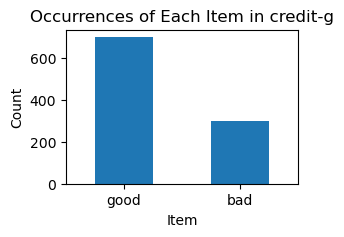

/home/beatriz/anaconda3/envs/machinelearning/lib/python3.12/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


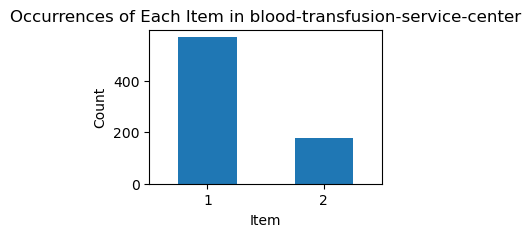

/home/beatriz/anaconda3/envs/machinelearning/lib/python3.12/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


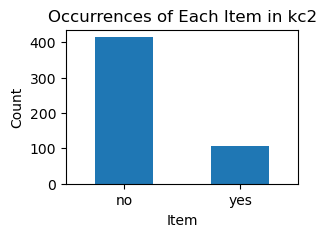

/home/beatriz/anaconda3/envs/machinelearning/lib/python3.12/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


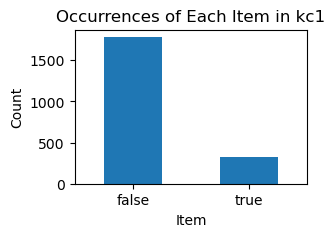

/home/beatriz/anaconda3/envs/machinelearning/lib/python3.12/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


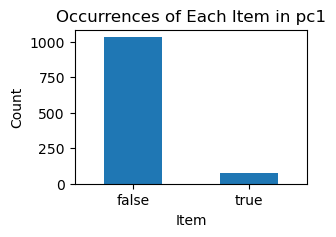

/home/beatriz/anaconda3/envs/machinelearning/lib/python3.12/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


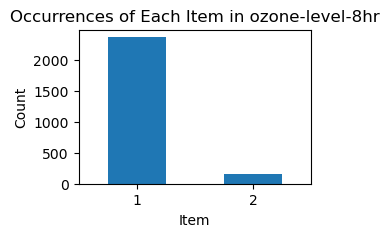

/home/beatriz/anaconda3/envs/machinelearning/lib/python3.12/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


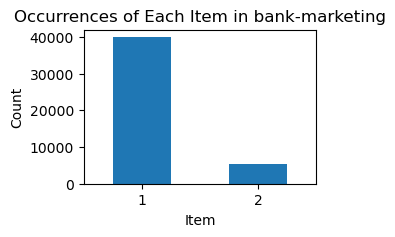

/home/beatriz/anaconda3/envs/machinelearning/lib/python3.12/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(
/home/beatriz/anaconda3/envs/machinelearning/lib/python3.12/site-packages/sklearn/datasets/_arff_parser.py:209: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  frame = pd.concat(dfs, ignore_index=True).fillna(value=np.nan)


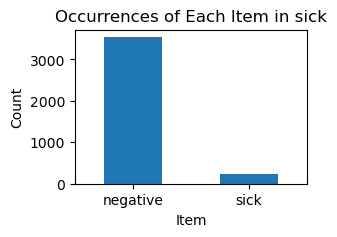

/home/beatriz/anaconda3/envs/machinelearning/lib/python3.12/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


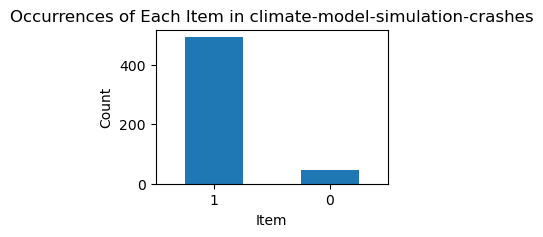

/home/beatriz/anaconda3/envs/machinelearning/lib/python3.12/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


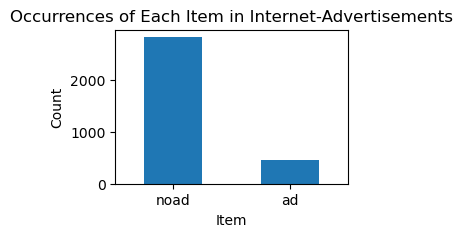

In [9]:
dataset_id_list = [31, 1464, 1063, 1067, 1068, 1487, 1461, 38, 40994, 40978]

data_generation_pipeline(dataset_id_list)